In [1]:
import sys
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import os
import bigbadbrain as bbb
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
from scipy.ndimage.filters import gaussian_filter
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

from skimage.filters import threshold_triangle
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages')
import os
import statsmodels.api as sm
import cv2
import matplotlib.patches as mpatches
import psutil
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.colors import Normalize


%matplotlib inline
plt.rcParams.update({'font.size': 20})

from sklearn.feature_extraction.image import grid_to_graph
from mpl_toolkits.axes_grid1 import ImageGrid
import json
from matplotlib.ticker import FuncFormatter

import nibabel as nib

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import itertools
import random
from scipy.cluster import hierarchy
import matplotlib as mpl
from matplotlib.pyplot import cm

from scipy.interpolate import UnivariateSpline
from sklearn.linear_model import LinearRegression
import matplotlib.patches as patches

from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV

from scipy.fftpack import fft,fftshift,ifft
from scipy import signal

In [2]:
fly_names = ['fly_087', 'fly_089', 'fly_094', 'fly_097', 'fly_098', 'fly_099', 'fly_100', 'fly_101', 'fly_105']
dataset_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset"
expt_len = 1000*30*60
resolution = 10
high_res_timepoints = np.arange(0,expt_len,resolution) #0 to last time at subsample res

class Fly:
    def __init__ (self, fly_name, fly_idx):
        self.dir = os.path.join(dataset_path, fly_name, 'func_0')
        self.fly_idx = fly_idx
        self.fly_name = fly_name
        self.maps = {}
    def load_timestamps (self):
        self.timestamps = bbb.load_timestamps(os.path.join(self.dir, 'imaging'))
    def load_fictrac (self):
        self.fictrac = Fictrac(self.dir, self.timestamps)
    def load_brain_slice (self):
        self.brain = brain[:,:,:,self.fly_idx]
    def load_anatomy (self):
        to_load = os.path.join(dataset_path, self.fly_name, 'warp', 'anat-to-meanbrain.nii')
        self.anatomy = np.array(nib.load(to_load).get_data(), copy=True)
    def load_z_depth_correction (self):
        to_load = os.path.join(dataset_path, self.fly_name, 'warp', '20201220_warped_z_depth.nii')
        self.z_correction = np.array(nib.load(to_load).get_data(), copy=True)
    def get_cluster_averages (self, cluster_model_labels, n_clusters):
        neural_data = self.brain.reshape(-1, 3384)
        signals = []
        self.cluster_indicies = []
        for cluster_num in range(n_clusters):
            cluster_indicies = np.where(cluster_model_labels==cluster_num)[0]
            mean_signal = np.mean(neural_data[cluster_indicies,:], axis=0)
            signals.append(mean_signal)
            self.cluster_indicies.append(cluster_indicies) # store for later
        self.cluster_signals=np.asarray(signals)
    def get_cluster_id (self, x, y):
        ax_vec = x*128 + y
        for i in range(n_clusters):
            if ax_vec in self.cluster_indicies[i]:
                cluster_id = i
                break
        return cluster_id

In [3]:
#####################
### Load Master X ###
#####################
file = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210316_neural_weighted_behavior/master_X.npy"
X = np.load(file)

#####################
### Make Clusters ###
#####################
n_clusters = 2000
labels_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20201129_super_slices/cluster_labels.npy'
cluster_model_labels_all = np.load(labels_file)

###################
### Build Flies ###
###################
flies = {}
for i, fly in enumerate(fly_names):
    flies[fly] = Fly(fly_name=fly, fly_idx=i)
    flies[fly].load_timestamps()
    flies[fly].load_z_depth_correction()


~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 79.94 ms

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 64.98 ms

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 33.59 ms

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 49.64 ms

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 40.44 ms

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 51.35 ms

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 28.96 ms

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 36.82 ms

~~ load_timestamps ~~
Trying to load timestamp 

In [4]:
z = 29

#######################
### Load Superslice ###
#######################
brain_file = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20201129_super_slices/superslice_{}.nii".format(z) #<---------- !!!
brain = np.array(nib.load(brain_file).get_data(), copy=True)
fly_idx_delete = 3 #(fly_095)
brain = np.delete(brain, fly_idx_delete, axis=-1) #### DELETING FLY_095 ####

# Get cluster responses for this slice
for fly in fly_names:
    flies[fly].load_brain_slice()
    flies[fly].get_cluster_averages(cluster_model_labels_all[z,:], n_clusters)

In [5]:
#################
### Main Loop ###
#################
cluster_num = 7

###############################################################
### Build Y vector for a single supervoxel (with all flies) ###
###############################################################
all_fly_neural = []
for fly in fly_names:
    signal = flies[fly].cluster_signals[cluster_num,:]
    all_fly_neural.extend(signal)
Y = np.asarray(all_fly_neural)

###########################################
### Build the X matrix for this cluster ###
###########################################
# For each fly, this cluster could have originally come from a different z-depth
# Get correct original z-depth
Xs_new = []
for i, fly in enumerate(fly_names):
    cluster_indicies = flies[fly].cluster_indicies[cluster_num]
    z_map = flies[fly].z_correction[:,:,z].ravel()
    original_z = int(np.median(z_map[cluster_indicies]))
    Xs_new.append(X[original_z,i,:,:])
Xs_new = np.asarray(Xs_new)
X_cluster = np.reshape(np.moveaxis(Xs_new,0,1),(-1,30456))

###################
### Dot Product ###
###################
cluster_response = np.dot(X_cluster,Y)

In [6]:
X_cluster.shape, Y.shape

((2000, 30456), (30456,))

In [6]:
X_cluster.shape, Y.shape

((2000, 30456), (30456,))

In [8]:
save_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210514_for_aws/X'
np.save(save_file, X_cluster[:500,:].T)
save_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210514_for_aws/Y'
np.save(save_file, Y)

In [9]:
X_cluster[:500,:].T.shape

(30456, 500)

In [32]:
X_cluster.shape, Y.shape

((2000, 30456), (30456,))

In [52]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression

In [210]:
t0 = time.time()
models = {}
models['linear'] = LinearRegression().fit(X_cluster[:500,:].T,Y)
models['lasso_cv'] = LassoCV().fit(X_cluster[:500,:].T,Y)
models['ridge_cv'] = RidgeCV().fit(X_cluster[:500,:].T,Y)
models['elasticnet_cv'] = ElasticNetCV().fit(X_cluster[:500,:].T,Y)
print(time.time()-t0)

30.805887460708618


In [217]:
X_cluster.shape

(2000, 30456)

In [222]:
models['ridge_cv'] = RidgeCV().fit(X_cluster[:500,:3384].T,Y[:3384])

In [224]:
models['ridge_cv'].score(X_cluster[:500,:3384].T,Y[:3384])**.5

0.17410706384501845

In [56]:
models['cross_corr'] = cluster_response[:500]

In [71]:
plt.rcParams.update({'font.size': 12})

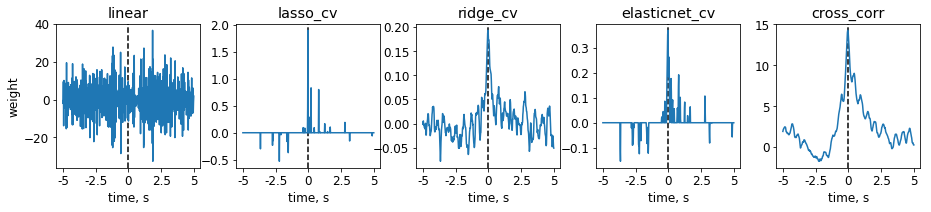

In [74]:
fig = plt.figure(figsize=(10,10))

for i, model in enumerate(models):
    ax = fig.add_axes([.25*i,1,.2,.2])
    plt.axvline(250,linestyle='--',color='k')
        
    if model != 'cross_corr':
        ax.plot(models[model].coef_[::-1])
    else:
        ax.plot(models[model][::-1])
        
    ax.set_title(model)
    plt.xticks([0,125,250,375,500],[-5,-2.5,0,2.5,5],fontsize=12)

    
    if i == 0:
        plt.ylabel('weight')
    plt.xlabel('time, s')

In [79]:
out = np.linalg.lstsq(X_cluster[:500,:].T,Y)

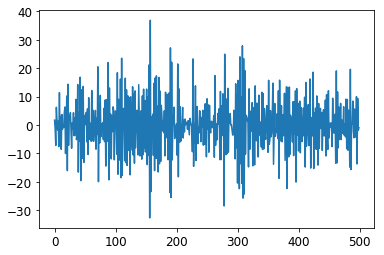

In [83]:
plt.plot(out[0])

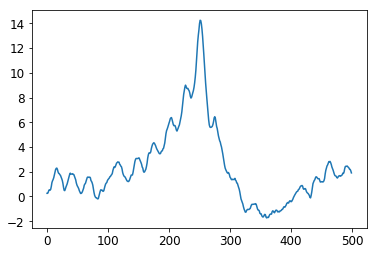

In [77]:
cluster_response = np.dot(X_cluster[:500,:],Y)
plt.plot(cluster_response[:500])

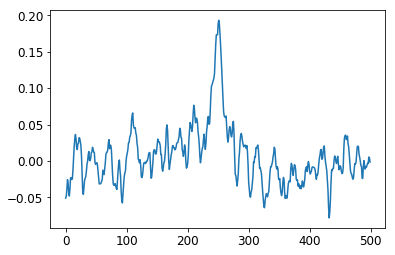

In [89]:
plt.plot(models['ridge_cv'].coef_)

In [92]:
ridge_notch = signal.filtfilt(b_notch, a_notch, models['ridge_cv'].coef_)
cross_notch = signal.filtfilt(b_notch, a_notch, models['cross_corr'])

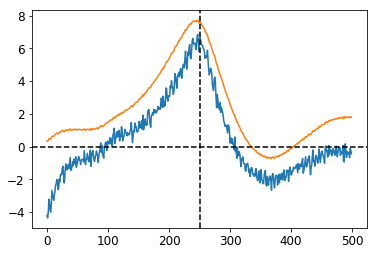

In [99]:
plt.plot(ridge_notch*100)
plt.plot(cross_notch)
plt.axhline(0,color='k',linestyle='--')
plt.axvline(250,color='k',linestyle='--')

In [100]:
models['ridge_cv'].predict(X)

SyntaxError: invalid syntax (<ipython-input-100-8765728cae81>, line 1)

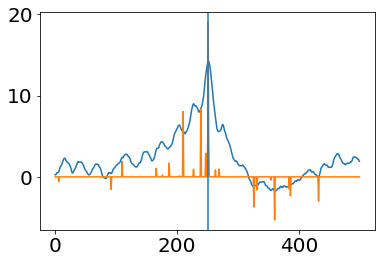

In [42]:
plt.plot(cluster_response[:500])
plt.plot(model.coef_*10)
plt.axvline(250)

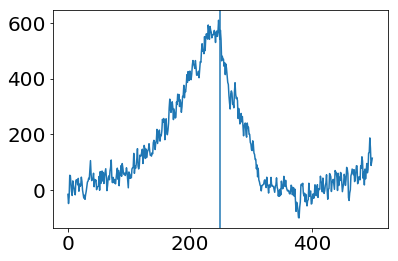

In [11]:
plt.plot(cluster_response[-500:])
plt.axvline(250)

In [16]:
main_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210316_neural_weighted_behavior"
#main_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210316_neural_weighted_behavior/corrected"

response_files = [os.path.join(main_path, file) for file in os.listdir(main_path) if 'responses' in file]
bbb.sort_nicely(response_files)

responses = []
for file in response_files:
    responses.append(np.load(file))
responses = np.asarray(responses)

responses_split = np.reshape(responses, (49-18,2000,4,500))

In [17]:
responses_split.shape

(31, 2000, 4, 500)

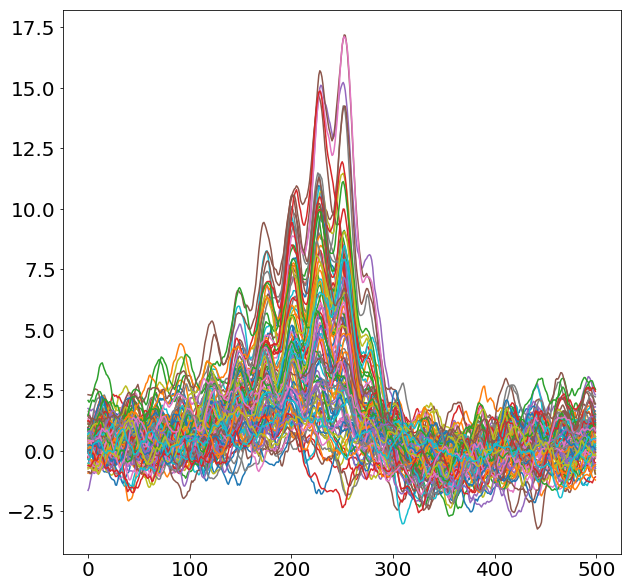

In [25]:
plt.figure(figsize=(10,10))
for i in range(100):
    plt.plot(responses_split[20,i,0,:])

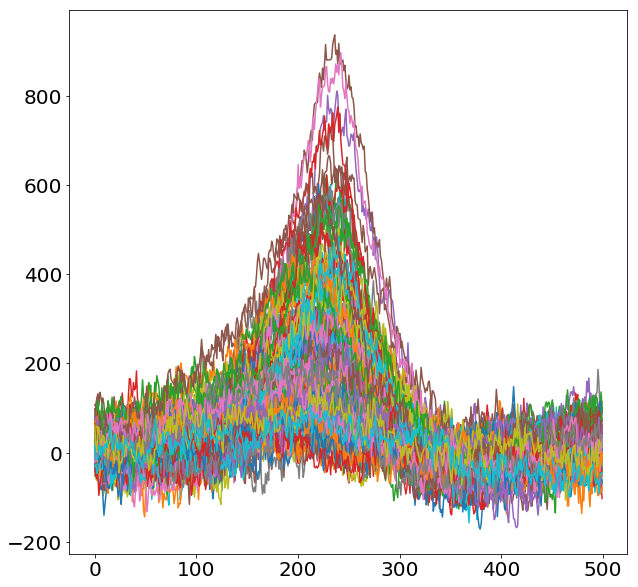

In [26]:
plt.figure(figsize=(10,10))
for i in range(100):
    plt.plot(responses_split[20,i,3,:])

In [102]:
###########################
### Create Notch Filter ###
###########################

fs = 50.0  # Sample frequency (Hz)
f0 = 1.8797  # Frequency to be removed from signal (Hz)
Q = 0.2  # Quality factor <---- IMPORTANT
w0 = f0/(fs/2)  # Normalized Frequency

# Design notch filter
b_notch, a_notch = signal.iirnotch(w0, Q)

# Frequency response
w, h = signal.freqz(b_notch, a_notch)

# Generate frequency axis
freq = w*fs/(2*np.pi)

# ##########################
# ### Apply notch filter ###
# ##########################

# outputSignal = signal.filtfilt(b_notch, a_notch, signal_corrupt)

In [29]:
responses_notch = signal.filtfilt(b_notch, a_notch, responses_split, axis=-1)

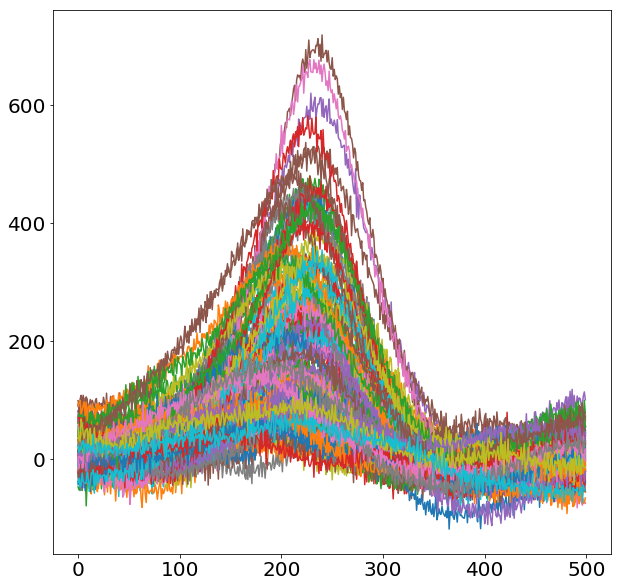

In [30]:
plt.figure(figsize=(10,10))
for i in range(100):
    plt.plot(responses_notch[20,i,3,:])

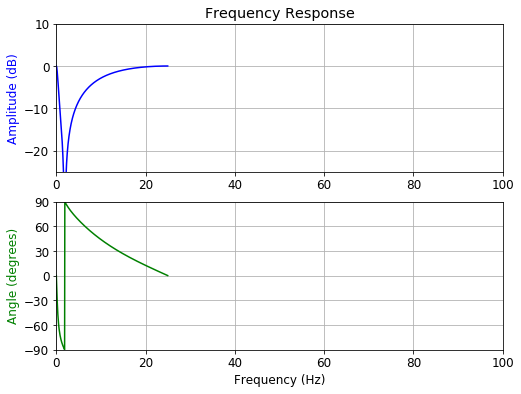

In [107]:
fs = 50.0  # Sample frequency (Hz)
f0 = 1.8797  # Frequency to be removed from signal (Hz)
Q = .2#0.2  # Quality factor <---- IMPORTANT
w0 = f0/(fs/2)  # Normalized Frequency

# Design notch filter
b_notch, a_notch = signal.iirnotch(w0, Q)

# Frequency response
w, h = signal.freqz(b_notch, a_notch)

# Generate frequency axis
freq = w*fs/(2*np.pi)
# # Plot
fig, ax = plt.subplots(2, 1, figsize=(8, 6))
ax[0].plot(freq, 20*np.log10(abs(h)), color='blue')
ax[0].set_title("Frequency Response")
ax[0].set_ylabel("Amplitude (dB)", color='blue')
ax[0].set_xlim([0, 100])
ax[0].set_ylim([-25, 10])
ax[0].grid()
ax[1].plot(freq, np.unwrap(np.angle(h))*180/np.pi, color='green')
ax[1].set_ylabel("Angle (degrees)", color='green')
ax[1].set_xlabel("Frequency (Hz)")
ax[1].set_xlim([0, 100])
ax[1].set_yticks([-90, -60, -30, 0, 30, 60, 90])
ax[1].set_ylim([-90, 90])
ax[1].grid()
plt.show()

### try convolving filter to predict behavior

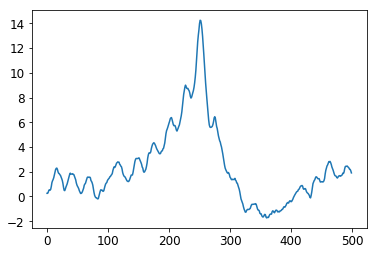

In [108]:
plt.plot(models['cross_corr'])

In [145]:
class Fly:
    def __init__ (self, fly_name, fly_idx):
        self.dir = os.path.join(dataset_path, fly_name, 'func_0')
        self.fly_idx = fly_idx
        self.fly_name = fly_name
        self.maps = {}
    def load_timestamps (self):
        self.timestamps = bbb.load_timestamps(os.path.join(self.dir, 'imaging'))
    def load_fictrac (self):
        self.fictrac = Fictrac(self.dir, self.timestamps)
    def load_brain_slice (self):
        self.brain = brain[:,:,:,self.fly_idx]
    def load_anatomy (self):
        to_load = os.path.join(dataset_path, self.fly_name, 'warp', 'anat-to-meanbrain.nii')
        self.anatomy = np.array(nib.load(to_load).get_data(), copy=True)
    def load_z_depth_correction (self):
        to_load = os.path.join(dataset_path, self.fly_name, 'warp', '20201220_warped_z_depth.nii')
        self.z_correction = np.array(nib.load(to_load).get_data(), copy=True)
    def get_cluster_averages (self, cluster_model_labels, n_clusters):
        neural_data = self.brain.reshape(-1, 3384)
        signals = []
        self.cluster_indicies = []
        for cluster_num in range(n_clusters):
            cluster_indicies = np.where(cluster_model_labels==cluster_num)[0]
            mean_signal = np.mean(neural_data[cluster_indicies,:], axis=0)
            signals.append(mean_signal)
            self.cluster_indicies.append(cluster_indicies) # store for later
        self.cluster_signals=np.asarray(signals)
    def get_cluster_id (self, x, y):
        ax_vec = x*128 + y
        for i in range(n_clusters):
            if ax_vec in self.cluster_indicies[i]:
                cluster_id = i
                break
        return cluster_id

class Fictrac:
    def __init__ (self, fly_dir, timestamps):
        self.fictrac_raw = bbb.load_fictrac(os.path.join(fly_dir, 'fictrac'))
        self.timestamps = timestamps
    def make_interp_object(self, behavior):
        # Create camera timepoints
        fps=50
        camera_rate = 1/fps * 1000 # camera frame rate in ms
        expt_len = 1000*30*60
        x_original = np.arange(0,expt_len,camera_rate)

        # Smooth raw fictrac data
        fictrac_smoothed = scipy.signal.savgol_filter(np.asarray(self.fictrac_raw[behavior]),25,3)

        # Create interp object with camera timepoints
        fictrac_interp_object = interp1d(x_original, fictrac_smoothed, bounds_error = False)
        return fictrac_interp_object

    def pull_from_interp_object(self, interp_object, timepoints):
        new_interp = interp_object(timepoints)
        np.nan_to_num(new_interp, copy=False);
        return new_interp

    def interp_fictrac(self, z):
        behaviors = ['dRotLabY', 'dRotLabZ']; shorts = ['Y', 'Z']
        self.fictrac = {}
        
        expt_len = 1000*30*60
        resolution = 20
        high_res_timepoints = np.arange(0,expt_len,resolution) #0 to last time at subsample res

        for behavior, short in zip(behaviors, shorts):
            interp_object = self.make_interp_object(behavior)
            self.fictrac[short + 'i'] = interp_object

            ### Velocity ###
            #low_res_behavior = self.pull_from_interp_object(interp_object, self.timestamps[:,z])
            high_res_behavior = self.pull_from_interp_object(interp_object, high_res_timepoints)
            self.fictrac[short] = high_res_behavior#/np.std(low_res_behavior)

            ### Clipped Velocities ###
            self.fictrac[short + '_pos'] = np.clip(self.fictrac[short], a_min=0, a_max=None)
            self.fictrac[short + '_neg'] = np.clip(self.fictrac[short], a_min=None, a_max=0)*-1

            ### Strongly Clipped Velocities ###
            # excludes points even close to 0
            #self.fictrac[short + '_pos_very'] = np.clip(self.fictrac[short], a_min=0.3, a_max=None)
            #self.fictrac[short + '_neg_very'] = np.clip(self.fictrac[short], a_min=None, a_max=-0.3)*-1

            ### Acceleration ###
            high_res_behavior = self.pull_from_interp_object(interp_object, high_res_timepoints)
            self.fictrac[short + 'h'] = high_res_behavior/np.std(high_res_behavior)

            accel = scipy.signal.savgol_filter(np.diff(high_res_behavior),25,3)
            accel = np.append(accel, 0)
            interp_object = interp1d(high_res_timepoints, accel, bounds_error = False)
            acl = interp_object(self.timestamps[:,z])
            acl[-1] = 0
            self.fictrac[short + 'a'] = acl#/np.std(acl)

            ### Clipped Acceleration ###
            self.fictrac[short + 'a' + '_pos'] = np.clip(self.fictrac[short + 'a'], a_min=0, a_max=None)
            self.fictrac[short + 'a' + '_neg'] = np.clip(self.fictrac[short + 'a'], a_min=None, a_max=0)*-1

        self.fictrac['YZ'] = np.sqrt(np.power(self.fictrac['Y'],2), np.power(self.fictrac['Z'],2))
        self.fictrac['YZh'] = np.sqrt(np.power(self.fictrac['Yh'],2), np.power(self.fictrac['Zh'],2))

In [146]:
fly_names = ['fly_087', 'fly_089', 'fly_094', 'fly_097', 'fly_098', 'fly_099', 'fly_100', 'fly_101', 'fly_105']
dataset_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset"
expt_len = 1000*30*60
resolution = 20
high_res_timepoints = np.arange(0,expt_len,resolution) #0 to last time at subsample res

#######################
### Load Superslice ###
#######################
brain_file = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20201129_super_slices/superslice_{}.nii".format(z) #<---------- !!!
brain = np.array(nib.load(brain_file).get_data(), copy=True)
fly_idx_delete = 3 #(fly_095)
brain = np.delete(brain, fly_idx_delete, axis=-1) #### DELETING FLY_095 ####

#####################
### Load Clusters ###
#####################

n_clusters = 2000
#labels_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20201129_super_slices/final_9_cluster_labels_2000.npy'
labels_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20201129_super_slices/cluster_labels.npy'
cluster_model_labels = np.load(labels_file)
cluster_model_labels = cluster_model_labels[z,:]

###################
### Build Flies ###
###################
flies = {}
for i, fly in enumerate(fly_names):
    flies[fly] = Fly(fly_name=fly, fly_idx=i)
    flies[fly].load_timestamps()
    flies[fly].load_fictrac()
    flies[fly].fictrac.interp_fictrac(z)
    flies[fly].load_brain_slice()
    flies[fly].load_z_depth_correction()
    flies[fly].get_cluster_averages(cluster_model_labels, n_clusters)

#####################
### Pool behavior ###
#####################
not_clipped_behaviors = ['Y', 'Z', 'Ya', 'Za']
clipped_behaviors = ['Y_pos', 'Y_neg',
                     'Z_pos', 'Z_neg',
                     'Ya_pos', 'Ya_neg',
                     'Za_pos', 'Za_neg']
all_behaviors = not_clipped_behaviors + clipped_behaviors

pooled_behavior = {}
for j, behavior in enumerate(all_behaviors):
    pooled_behavior[behavior] = []
    for i,fly in enumerate(flies):
        pooled_behavior[behavior].append(flies[fly].fictrac.fictrac[behavior])
    pooled_behavior[behavior] = np.asarray(pooled_behavior[behavior]).flatten()


~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 7.75 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 2.93 sec

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 7.77 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 2.90 sec

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 12.38 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 2.98 sec

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 16.32 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 2.98 sec

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 17.30 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 2.80 sec

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 12.33 m

In [151]:
fly = 'fly_087'

cluster_indicies = flies[fly].cluster_indicies[7]
z_map = flies[fly].z_correction[:,:,z].ravel()
original_z = int(np.median(z_map[cluster_indicies]))

In [159]:
interp_object = interp1d(flies[fly].timestamps[:,original_z], Y[:3384], bounds_error = False)
neural_high_res = interp_object(high_res_timepoints)

In [199]:
### r value without convolution ###

r, p = scipy.stats.pearsonr(np.nan_to_num(neural_high_res), np.nan_to_num(pooled_behavior['Y_pos'][:90000]))
r, p

(0.1428414288983607, 0.0)

In [200]:
### r value after convolution - cross corr ###

neural_convolved = np.convolve(np.nan_to_num(neural_high_res), models['cross_corr'], mode='same')

r, p = scipy.stats.pearsonr(np.nan_to_num(neural_convolved), np.nan_to_num(pooled_behavior['Y_pos'][:90000]))
r,p

(0.14838709369240255, 0.0)

In [205]:
### r value after convolution - ridge ###

neural_convolved = np.convolve(np.nan_to_num(neural_high_res), models['ridge_cv'].coef_, mode='same')

r, p = scipy.stats.pearsonr(np.nan_to_num(neural_convolved), np.nan_to_num(pooled_behavior['Y_pos'][:90000]))
r,p

(0.14838259522316335, 0.0)

In [206]:
### r value after convolution - ridge notched ###

neural_convolved = np.convolve(np.nan_to_num(neural_high_res), ridge_notch, mode='same')

r, p = scipy.stats.pearsonr(np.nan_to_num(neural_convolved), np.nan_to_num(pooled_behavior['Y_pos'][:90000]))
r,p

(0.12779961893816355, 5e-324)

In [207]:
### r value after convolution - cross corr notched ###

neural_convolved = np.convolve(np.nan_to_num(neural_high_res), cross_notch, mode='same')

r, p = scipy.stats.pearsonr(np.nan_to_num(neural_convolved), np.nan_to_num(pooled_behavior['Y_pos'][:90000]))
r,p

(0.13617961798239825, 0.0)

### in summary, convolving with filter increases r slightly. cross corr and ridge filters give similar r. notching hurts r

### pushing ridge farther: want to fit all filters simultaneously. 

In [ ]:
### will be a memory issue! one solution could be to fit them separately
# 

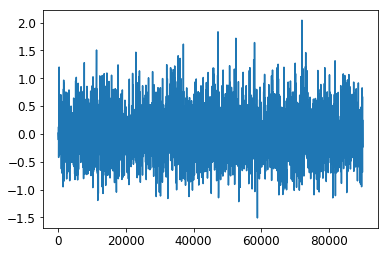

In [160]:
plt.plot(neural_high_res)

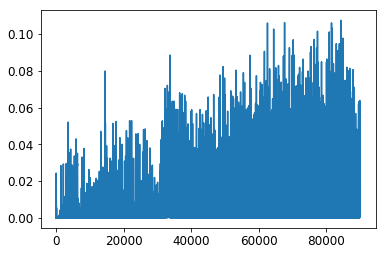

In [161]:
plt.plot(pooled_behavior['Y_pos'][:90000])

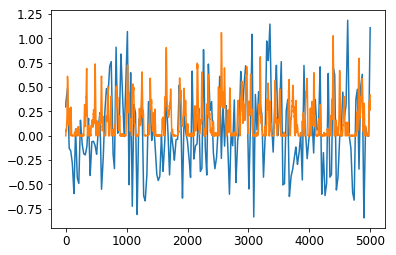

In [166]:
plt.plot(neural_high_res[60000:65000])
plt.plot(pooled_behavior['Y_pos'][60000:65000]*10)

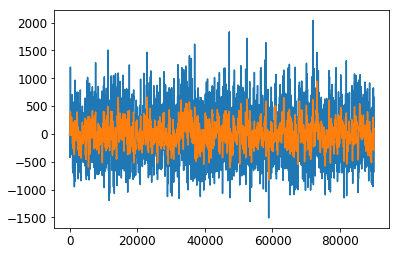

In [184]:
plt.plot(neural_high_res*1000)
plt.plot(neural_convolved)

In [198]:
r, p = scipy.stats.pearsonr(np.nan_to_num(neural_convolved), np.nan_to_num(pooled_behavior['Y_pos'][:90000]))
r,p

(0.14838709369240255, 0.0)

In [187]:
r, p = scipy.stats.pearsonr(np.nan_to_num(neural_convolved), np.nan_to_num(pooled_behavior['Y_pos'][:90000]))
r, p

(0.13073040751329698, 0.0)

In [193]:
behavior_convolved = np.convolve(np.nan_to_num(pooled_behavior['Y_pos'][:90000]), models['cross_corr'][::-1], mode='same')

In [194]:
r, p = scipy.stats.pearsonr(np.nan_to_num(neural_high_res), behavior_convolved)
r,p

(0.1345535016666595, 0.0)

In [155]:
flies[fly].timestamps[:,original_z].shape

(3384,)

In [149]:
pooled_behavior['Y_pos'].shape

(810000,)

In [150]:
810000/9

90000.0

In [130]:
Y.shape

(30456,)

In [135]:
flies['fly_087'].timestamps[:,z]

array([3.57570881e+02, 8.89566582e+02, 1.42156228e+03, ...,
       1.79903504e+06, 1.79956703e+06, 1.80009903e+06])

In [152]:
original_z

31

In [2]:
dataset_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset"

In [3]:
fly_names = ['fly_087', 'fly_089', 'fly_094', 'fly_095', 'fly_097', 'fly_098', 'fly_099', 'fly_100', 'fly_101', 'fly_105']
expt_len = 1000*30*60
resolution = 10
high_res_timepoints = np.arange(0,expt_len,resolution) #0 to last time at subsample res

In [4]:
z=20
n_clusters = 2000
labels_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20201129_super_slices/cluster_labels.npy'
cluster_model_labels = np.load(labels_file)
cluster_model_labels = cluster_model_labels[z,:]

In [5]:
brain_file = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20201129_super_slices/superslice_{}.nii".format(z) #<---------- !!!
brain = np.array(nib.load(brain_file).get_data(), copy=True)

In [6]:
class Fictrac:
    def __init__ (self, fly_dir, timestamps):
        self.fictrac_raw = bbb.load_fictrac(os.path.join(fly_dir, 'fictrac'))
        self.timestamps = timestamps
    def make_interp_object(self, behavior):
        # Create camera timepoints
        fps=50
        camera_rate = 1/fps * 1000 # camera frame rate in ms
        expt_len = 1000*30*60
        x_original = np.arange(0,expt_len,camera_rate)

        # Smooth raw fictrac data
        fictrac_smoothed = scipy.signal.savgol_filter(np.asarray(self.fictrac_raw[behavior]),25,3)

        # Create interp object with camera timepoints
        fictrac_interp_object = interp1d(x_original, fictrac_smoothed, bounds_error = False)
        return fictrac_interp_object

    def pull_from_interp_object(self, interp_object, timepoints):
        new_interp = interp_object(timepoints)
        np.nan_to_num(new_interp, copy=False);
        return new_interp

    def interp_fictrac(self, z):
        behaviors = ['dRotLabY', 'dRotLabZ']; shorts = ['Y', 'Z']
        self.fictrac = {}

        for behavior, short in zip(behaviors, shorts):
            interp_object = self.make_interp_object(behavior)
            self.fictrac[short + 'i'] = interp_object

            ### Velocity ###
            low_res_behavior = self.pull_from_interp_object(interp_object, self.timestamps[:,z])
            self.fictrac[short] = low_res_behavior#/np.std(low_res_behavior)

            ### Clipped Velocities ###
            self.fictrac[short + '_pos'] = np.clip(self.fictrac[short], a_min=0, a_max=None)
            self.fictrac[short + '_neg'] = np.clip(self.fictrac[short], a_min=None, a_max=0)*-1

            ### Strongly Clipped Velocities ###
            # excludes points even close to 0
            #self.fictrac[short + '_pos_very'] = np.clip(self.fictrac[short], a_min=0.3, a_max=None)
            #self.fictrac[short + '_neg_very'] = np.clip(self.fictrac[short], a_min=None, a_max=-0.3)*-1

            ### Acceleration ###
            high_res_behavior = self.pull_from_interp_object(interp_object, high_res_timepoints)
            self.fictrac[short + 'h'] = high_res_behavior/np.std(high_res_behavior)

            accel = scipy.signal.savgol_filter(np.diff(high_res_behavior),25,3)
            accel = np.append(accel, 0)
            interp_object = interp1d(high_res_timepoints, accel, bounds_error = False)
            acl = interp_object(self.timestamps[:,z])
            acl[-1] = 0
            self.fictrac[short + 'a'] = acl#/np.std(acl)

            ### Clipped Acceleration ###
            self.fictrac[short + 'a' + '_pos'] = np.clip(self.fictrac[short + 'a'], a_min=0, a_max=None)
            self.fictrac[short + 'a' + '_neg'] = np.clip(self.fictrac[short + 'a'], a_min=None, a_max=0)*-1

        self.fictrac['YZ'] = np.sqrt(np.power(self.fictrac['Y'],2), np.power(self.fictrac['Z'],2))
        self.fictrac['YZh'] = np.sqrt(np.power(self.fictrac['Yh'],2), np.power(self.fictrac['Zh'],2))

In [7]:
class Fly:
    def __init__ (self, fly_name, fly_idx):
        self.dir = os.path.join(dataset_path, fly_name, 'func_0')
        self.fly_idx = fly_idx
        self.fly_name = fly_name
        self.maps = {}
    def load_timestamps (self):
        self.timestamps = bbb.load_timestamps(os.path.join(self.dir, 'imaging'))
    def load_fictrac (self):
        self.fictrac = Fictrac(self.dir, self.timestamps)
    def load_brain_slice (self):
        self.brain = brain[:,:,:,self.fly_idx]
    def load_anatomy (self):
        to_load = os.path.join(dataset_path, self.fly_name, 'warp', 'anat-to-meanbrain.nii')
        self.anatomy = np.array(nib.load(to_load).get_data(), copy=True)
    def load_z_depth_correction (self):
        to_load = os.path.join(dataset_path, self.fly_name, 'warp', '20201220_warped_z_depth.nii')
        self.z_correction = np.array(nib.load(to_load).get_data(), copy=True)
    def get_cluster_averages (self, cluster_model_labels, n_clusters):
        neural_data = self.brain.reshape(-1, 3384)
        signals = []
        self.cluster_indicies = []
        for cluster_num in range(n_clusters):
            cluster_indicies = np.where(cluster_model_labels==cluster_num)[0]
            mean_signal = np.mean(neural_data[cluster_indicies,:], axis=0)
            signals.append(mean_signal)
            self.cluster_indicies.append(cluster_indicies) # store for later
        self.cluster_signals=np.asarray(signals)
    def get_cluster_id (self, x, y):
        ax_vec = x*128 + y
        for i in range(n_clusters):
            if ax_vec in self.cluster_indicies[i]:
                cluster_id = i
                break
        return cluster_id


In [8]:
flies = {}
for i, fly in enumerate(fly_names):
    flies[fly] = Fly(fly_name=fly, fly_idx=i)
    flies[fly].load_timestamps()
    flies[fly].load_fictrac()
    flies[fly].fictrac.interp_fictrac(z)
    flies[fly].load_brain_slice()
    flies[fly].load_z_depth_correction()
    flies[fly].get_cluster_averages(cluster_model_labels, n_clusters)


~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 36.51 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 2.97 sec

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 61.90 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 3.09 sec

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 47.78 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 3.10 sec

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 46.98 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 3.03 sec

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 79.32 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 3.06 sec

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 68.99

In [10]:
# for a given fly and a given super voxel, this function should
# 1) find it's correct original z-depth based on the warped volume
# 2) create a matrix of timeshifts for each neural timepoint

In [22]:
# def build_timeshifted_behavior_matrix(time_shifts, fly, cluster, z, behavior):
#     # Get correct behavior interp obj
#     if 'Z' in behavior: behavior_i = 'Zi'
#     else: behavior_i = 'Yi'
#     interp_obj = flies[fly].fictrac.fictrac[behavior_i]
    
#     # Get correct original z-depth
#     cluster_indicies = flies[fly].cluster_indicies[cluster]
#     z_map = flies[fly].z_correction[:,:,z].ravel()
#     original_z = int(np.median(z_map[cluster_indicies]))

#     behavior_shifts = []
#     for shift in time_shifts:
#         fictrac_interp = interp_obj(flies[fly].timestamps[:,original_z]+shift)
#         fictrac_interp = np.nan_to_num(fictrac_interp)
#         if 'pos' in behavior:
#             fictrac_interp = np.clip(fictrac_interp, a_min=0, a_max=None)
#         if 'neg' in behavior:
#             fictrac_interp = np.clip(fictrac_interp, a_min=None, a_max=0)*-1
#         #fictrac_interp[np.where(fictrac_interp == 0)] = np.nan
#         behavior_shifts.append(fictrac_interp)

#     return time_shifts, behavior_shifts

In [23]:
# def build_X_Y (time_shifts, behaviors, cluster_num, z):
#     ###############################################################
#     ### Build X matrix for a single supervoxel (with all flies) ###
#     ###############################################################
#     all_fly_shifts = []
#     for fly in fly_names:
#         all_behavior_shifts = []
#         for behavior in behaviors:
#             time_shifts, behavior_shifts = build_timeshifted_behavior_matrix(time_shifts=time_shifts,
#                                                                              fly=fly,
#                                                                              cluster=cluster_num,
#                                                                              z=z,
#                                                                              behavior=behavior)
#             all_behavior_shifts.append(np.asarray(behavior_shifts))
#         all_behavior_shifts = np.asarray(all_behavior_shifts)
#         all_behavior_shifts = np.reshape(all_behavior_shifts, (-1,3384))
#         all_fly_shifts.append(all_behavior_shifts)
#     X = np.reshape(np.moveaxis(all_fly_shifts,0,1),(-1,33840)).T
    
#     ###############################################################
#     ### Build Y vector for a single supervoxel (with all flies) ###
#     ###############################################################
#     all_fly_neural = []
#     for fly in fly_names:
#         signal = flies[fly].cluster_signals[cluster_num,:]
#         all_fly_neural.extend(signal)
#     Y = np.asarray(all_fly_neural)

#     return X, Y

In [ ]:
# So apparently my neural-weighted behavior filters wrk way better than the GLMS!
# Let's change how I make the behavior X matrices so we can do all this calculation really fast

In [9]:
def build_timeshifted_behavior_matrix(time_shifts, fly, z, behavior):
    # Get correct behavior interp obj
    if 'Z' in behavior: behavior_i = 'Zi'
    else: behavior_i = 'Yi'
    interp_obj = flies[fly].fictrac.fictrac[behavior_i]

    behavior_shifts = []
    for shift in time_shifts:
        fictrac_interp = interp_obj(flies[fly].timestamps[:,z]+shift)
        fictrac_interp = np.nan_to_num(fictrac_interp)
        if 'pos' in behavior:
            fictrac_interp = np.clip(fictrac_interp, a_min=0, a_max=None)
        if 'neg' in behavior:
            fictrac_interp = np.clip(fictrac_interp, a_min=None, a_max=0)*-1
        #fictrac_interp[np.where(fictrac_interp == 0)] = np.nan
        behavior_shifts.append(fictrac_interp)

    return time_shifts, behavior_shifts

In [10]:
def build_X (time_shifts, behaviors, z):
    ###############################################################
    ### Build X matrix for a single supervoxel (with all flies) ###
    ###############################################################
    all_fly_shifts = []
    for fly in fly_names:
        all_behavior_shifts = []
        for behavior in behaviors:
            time_shifts, behavior_shifts = build_timeshifted_behavior_matrix(time_shifts=time_shifts,
                                                                             fly=fly,
                                                                             z=z,
                                                                             behavior=behavior)
            all_behavior_shifts.append(np.asarray(behavior_shifts))
        all_behavior_shifts = np.asarray(all_behavior_shifts)
        all_behavior_shifts = np.reshape(all_behavior_shifts, (-1,3384))
        all_fly_shifts.append(all_behavior_shifts)
    X = np.asarray(all_fly_shifts)
    return X

In [11]:
z=20
time_shifts = list(range(-5000,5000,20)) # in ms
behaviors = ['Y_pos', 'Z_pos', 'Z_neg']

###########################################
### Build the complete X behavior matrix ###
###########################################
Xs = []
for z in range(49):
    print(z)
    X = build_X(time_shifts, behaviors, z)
    Xs.append(X)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48


In [12]:
save_file = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20201221_neural_weighted_behavior/master_X"
np.save(save_file, np.asarray(Xs))

In [194]:
save_file = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20201221_neural_weighted_behavior"
os.mkdir(save_file)

In [13]:
os.listdir("/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20201221_neural_weighted_behavior")

['master_X.npy']

In [183]:
cluster_responses = []
for cluster_num in range(n_clusters):
    if cluster_num%100 == 0:
        print(cluster_num)
    ###############################################################
    ### Build Y vector for a single supervoxel (with all flies) ###
    ###############################################################
    all_fly_neural = []
    for fly in fly_names:
        signal = flies[fly].cluster_signals[cluster_num,:]
        all_fly_neural.extend(signal)
    Y = np.asarray(all_fly_neural)

    ###########################################
    ### Build the X matrix for this cluster ###
    ###########################################
    # For each fly, this cluster could have originally come from a different z-depth
    # Get correct original z-depth
    Xs_new = []
    for i, fly in enumerate(fly_names):
        cluster_indicies = flies[fly].cluster_indicies[cluster_num]
        z_map = flies[fly].z_correction[:,:,z].ravel()
        original_z = int(np.median(z_map[cluster_indicies]))
        Xs_new.append(Xs[original_z][i,:,:])
    Xs_new = np.asarray(Xs_new)
    X_cluster = np.reshape(np.moveaxis(Xs_new,0,1),(-1,33840))

    ###################
    ### Dot Product ###
    ###################
    cluster_response = np.dot(X_cluster,Y)
    cluster_responses.append(cluster_response)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900


In [190]:
cluster_responses = np.asarray(cluster_responses)

In [14]:
cluster_responses.shape

NameError: name 'cluster_responses' is not defined

In [15]:
file = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20201221_neural_weighted_behavior/responses_20.npy"
cluster_responses = np.load(file)

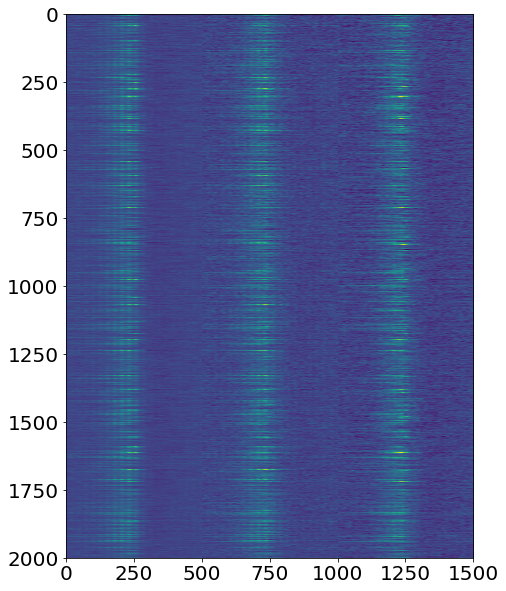

In [16]:
plt.figure(figsize=(10,10))
plt.imshow(cluster_responses)

In [ ]:
np.sum(cluster_responses[cluster_num][:500])

In [184]:
cluster_model_labels.shape

(32768,)

In [188]:
colored_by_betas = np.zeros(256*128)
for cluster_num in range(n_clusters):
    cluster_indicies = np.where(cluster_model_labels==cluster_num)[0]
    colored_by_betas[cluster_indicies] = np.sum(cluster_responses[cluster_num][500:1000])
colored_by_betas = colored_by_betas.reshape(256,128)

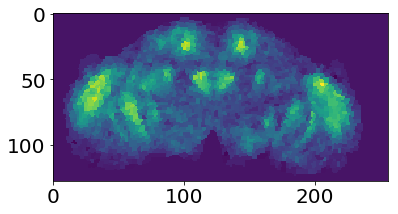

In [187]:
plt.imshow(colored_by_betas.T)

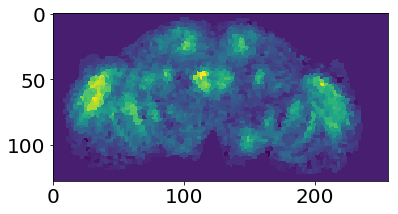

In [189]:
plt.imshow(colored_by_betas.T)

In [177]:
out = np.dot(X_cluster,Y)

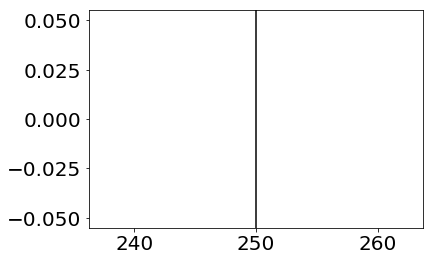

In [178]:
plt.plot(out[:500])
plt.plot(out[500:1000])
plt.plot(out[1000:])
plt.axvline(250,color='k')

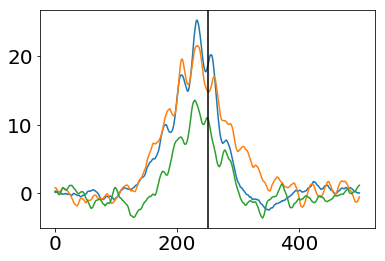

In [171]:
plt.plot(out[:500])
plt.plot(out[500:1000])
plt.plot(out[1000:])
plt.axvline(250,color='k')

In [146]:
256*128

32768

In [141]:
X.shape

(33840, 1500)

In [143]:
X.dtype

dtype('float64')

In [32]:
from sklearn.linear_model import ElasticNetCV

In [133]:
cluster_num = 1834
z = 20
#time_shifts = list(range(-1000,1000,10)) # in ms
time_shifts = list(range(-5000,5000,20)) # in ms
#time_shifts = list(range(-10000,10000,50)) # in ms
behaviors = ['Y_pos', 'Z_pos', 'Z_neg']
X, Y = build_X_Y (time_shifts, behaviors, cluster_num, z)
X.shape, Y.shape

((33840, 1500), (33840,))

In [134]:
out = np.dot(X.T,Y)

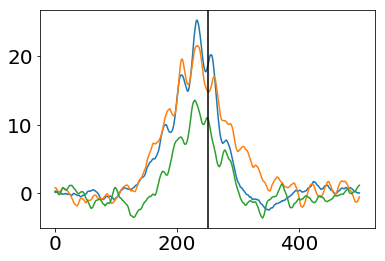

In [136]:
plt.plot(out[:500])
plt.plot(out[500:1000])
plt.plot(out[1000:])
plt.axvline(250,color='k')

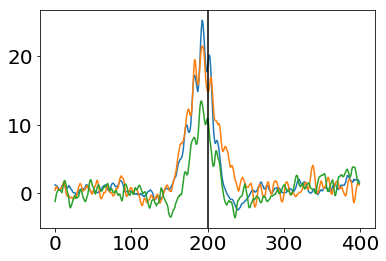

In [127]:
plt.plot(out[:400])
plt.plot(out[400:800])
plt.plot(out[800:])
plt.axvline(200,color='k')


In [122]:
out.shape

(1200,)

In [113]:
t0 = time.time()
model = RidgeCV().fit(X,Y)
print(time.time()-t0)

5.563788652420044


In [110]:
5.615224123001099*2000/60

187.17413743336996

In [111]:
32*2000/60

1066.6666666666667

In [109]:
t0 = time.time()
model = ElasticNetCV().fit(X,Y)
print(time.time()-t0)

32.85021162033081


In [74]:
model.score(X,Y)

0.06525223789517787

In [55]:
model.score(X,Y)

0.06401405080161182

In [41]:
np.sqrt(0.07823273564191158)

0.2797011541662129

In [39]:
model.score(X[:3384,:],Y[:3384])

0.05283327632085355

(0, 400)

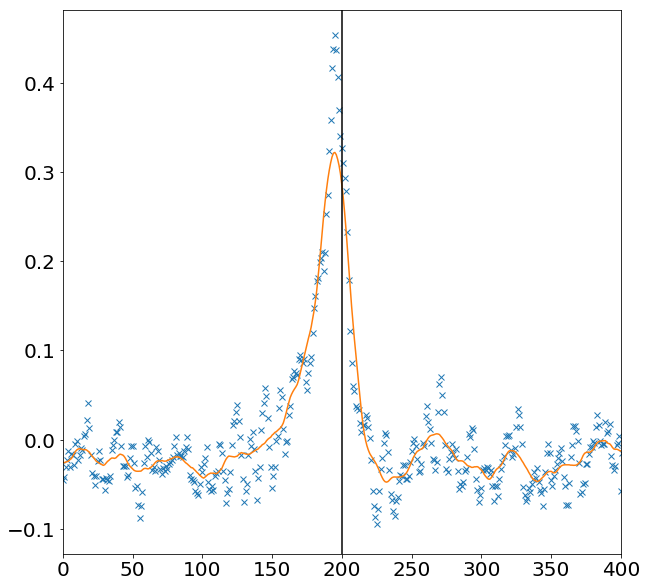

In [117]:
plt.figure(figsize=(10,10))
plt.plot(model.coef_,'x')
plt.plot(gaussian_filter(model.coef_,sigma=10,truncate=1))
#plt.plot(scipy.signal.savgol_filter(model.coef_,25,3))

plt.axvline(200,color='k')
plt.xlim(0,400)

(0, 400)

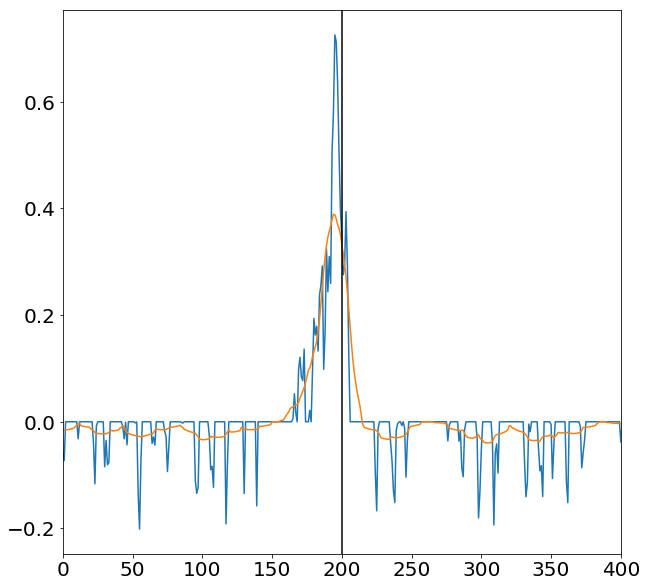

In [112]:
plt.figure(figsize=(10,10))
plt.plot(model.coef_)
plt.plot(gaussian_filter(model.coef_,sigma=10,truncate=1))
#plt.plot(scipy.signal.savgol_filter(model.coef_,25,3))

plt.axvline(200,color='k')
plt.xlim(0,400)

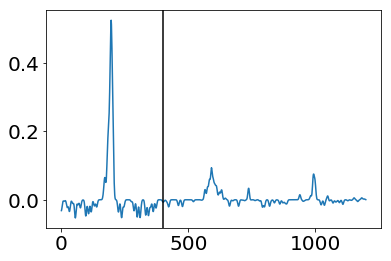

In [88]:
plt.plot(gaussian_filter(model.coef_,sigma=3))
plt.axvline(400,color='k')

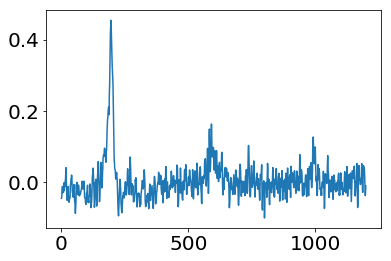

In [81]:
plt.plot(model.coef_)
#plt.axvline(400,color='k')

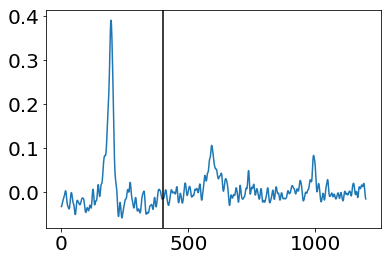

In [85]:
plt.plot(gaussian_filter(model.coef_,sigma=3))
plt.axvline(400,color='k')

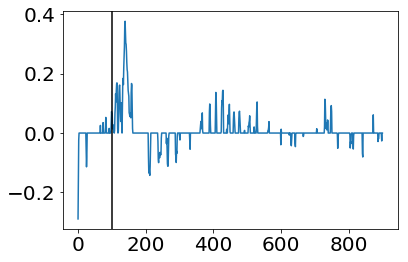

In [38]:
plt.plot(model.coef_)
plt.axvline(100,color='k')

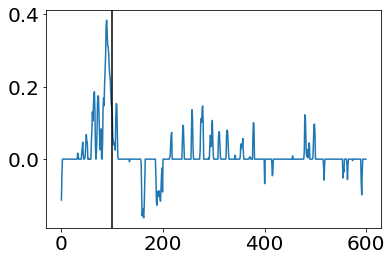

In [34]:
plt.plot(model.coef_)
plt.axvline(100,color='k')

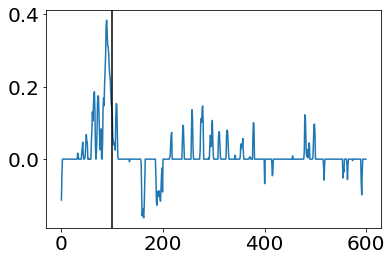

In [35]:
plt.plot(model.coef_)
plt.axvline(100,color='k')

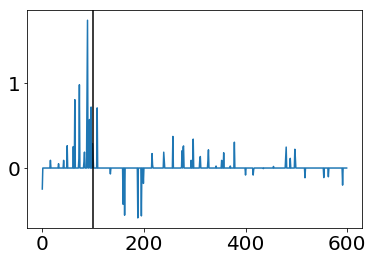

In [31]:
plt.plot(model.coef_)
plt.axvline(100,color='k')